In [1]:
import requests
import json
import warnings
from PyPDF2 import PdfReader
from io import BytesIO
import re

def get_list():
    url = "http://api.sejm.gov.pl/eli/acts"
    response = requests.get(url)
    return response.json()

def get_acts_list(publisher: str, year: int):
    url = f"http://api.sejm.gov.pl/eli/acts/{publisher}/{year}"
    try:
        response = requests.get(url)
        return response.json()
    except:
        warnings.warn(f"Couldn't get data from {url}")
        return None
    
def get_act(publisher: str, year: int, position: int):
    url = f"http://api.sejm.gov.pl/eli/acts/{publisher}/{year}/{position}"
    try:
        response = requests.get(url)
        return response.json()
    except:
        warnings.warn(f"Couldn't get data from {url}")
        return None
    
def get_act_text(publisher: str, year: int, position: int):
    url = f"http://api.sejm.gov.pl/eli/acts/{publisher}/{year}/{position}/text.pdf"
    try:
        response = requests.get(url)
        response.raise_for_status()
        pdf_content = response.content
        pdf_reader = PdfReader(BytesIO(pdf_content))
        text = ""
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += " " + page.extract_text()
        # Replace \n with space
        text = re.sub(r"\n", " ", text)
        # Remove multiple spaces
        text = re.sub(r"\s+", " ", text)
        return text[1:]
    except requests.exceptions.RequestException as e:
        warnings.warn(f"Couldn't get data from {url}: {e}")
        return None
    except Exception as e:
        warnings.warn(f"Error processing PDF: {e}")
        return None

In [ ]:
acts_list_DU_2024 = get_acts_list("DU", 2024)
acts_list_MP_2024 = get_acts_list("MP", 2024)
DU_2024_counts = acts_list_DU_2024['count']
MP_2024_counts = acts_list_MP_2024['count']

In [ ]:
from tqdm import tqdm

texts = []
metadatas = []

print("Downloading polish acts from 2024...")
for i in tqdm(range(1, DU_2024_counts + 1)):
    text = get_act_text("DU", 2024, i)
    if text is None:
        text = ''
    metadata = get_act("DU", 2024, i)
    texts.append(text)
    metadatas.append(metadata) 

print("Downloading polish acts from 2024...")
for i in tqdm(range(1, MP_2024_counts + 1)):
    text = get_act_text("MP", 2024, i)
    if text is None:
        text = ''
    metadata = get_act("MP", 2024, i)
    texts.append(text)
    metadatas.append(metadata) 

In [3]:
import pickle

with open('./data/texts.pkl', 'rb') as f:
    texts = pickle.load(f)

with open('./data/metadatas.pkl', 'rb') as f:
    metadatas = pickle.load(f)

In [6]:
# print max len from texts
max_len = 0
for text in texts:
    max_len = max(max_len, len(text))
max_len

1112567

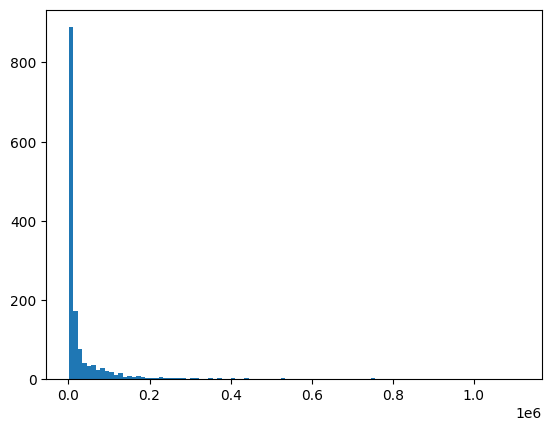

In [8]:
import matplotlib.pyplot as plt

# print histogram of lengths
plt.hist([len(text) for text in texts], bins=100)
plt.show()

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "speakleash/Bielik-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\szymo\.cache\huggingface\hub\models--speakleash--Bielik-7B-v0.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [14]:
import transformers

pipeline = transformers.pipeline('text-generation', model=model, tokenizer=tokenizer)

import random

def generate_text(text, max_length=1000):
    prompt = random.choice(text)
    return pipeline(prompt, max_length=max_length)[0]['generated_text']

generated_texts = []
for i in range(10):
    generated_texts.append(generate_text(texts, max_length=1000))

for text in generated_texts:
    print(text)
    print()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


KeyboardInterrupt: 

In [13]:
print(torch.cuda.is_available())

False


In [50]:
import re
from PyPDF2 import PdfReader

def parse_pdf(file_path):
    # Read and merge all text from the PDF
    reader = PdfReader(file_path)
    full_text = ""
    for page in reader.pages:
        full_text += page.extract_text() + "\n"

    # Remove footers like "©Kancelaria Sejmu s. 1/56, 2015-01-07"
    full_text = re.sub(r"©Kancelaria Sejmu\.?", "", full_text, flags=re.DOTALL)
    full_text = re.sub(r"\d\s*\d\s*\d\s*\d\s*-\s*\d\s*\d\s*-\s*\d\s*\d", "", full_text, flags=re.DOTALL)
    full_text = re.sub(r"s\.\s*\d+\s*/\s*\d+", "", full_text, flags=re.IGNORECASE)

    # Split into lines for easier parsing
    lines = full_text.split("\n")
    
    data = []
    current_section = None
    current_section_title = None
    # current_subsection_title = None
    current_article = None
    text_buffer = []

    def save_current_article():
        if current_article and text_buffer:
            data.append({
                "section": current_section,
                "section_title": current_section_title,
                # "subsection_title": current_subsection_title,
                "article": current_article,
                "text": " ".join(text_buffer).strip()
            })

    for line in lines:
        line = line.strip()

        # Detect section titles (Rozdział)
        section_match = re.search(r"ROZDZIAŁ\s+([IVXLCDM]+)", line, re.IGNORECASE)
        if section_match:
            save_current_article()
            current_section = section_match.group(1)
            current_section_title = None
            # current_subsection_title = None
            current_article = None
            text_buffer = []
            continue

        # Detect section title (uppercase, just under the section)
        if current_section and not current_section_title and line.isupper():
            current_section_title = line
            continue

        # # Detect subsection title (sentence case, as close as possible to articles)
        # if current_section and current_section_title and not current_subsection_title and line[0].isupper() and not line.isupper():
        #     current_subsection_title = line
        #     continue

        # Detect articles
        article_match = re.match(r"^Art\.\s*(\d+)\.", line)
        if article_match:
            save_current_article()
            current_article = article_match.group(1)
            text_buffer = []
            line = line[article_match.end():].strip()

        # Collect the text for the current article
        if line:
            text_buffer.append(line)

    # Save the last article
    save_current_article()

    return data

In [51]:
# Parse the PDF and save the results
pdf_path = "konstytucja.pdf"  # Replace with your file path
output = parse_pdf(pdf_path)

# Save as JSON or process further
import json
with open("parsed_constitution.json", "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

print(f"Extracted {len(output)} articles.")


Extracted 243 articles.


In [53]:
# get all sections
sections = []
for article in output:
    sections.append(article['section'])
sections = list(set(sections))
sections

['XII',
 'VI',
 'VIII',
 'XI',
 'V',
 'IV',
 'X',
 'XIII',
 'I',
 'III',
 'IX',
 'VII',
 'II']